Choose any values you want, run all the code, and check back when completed. At the very bottom will 3 savings plans.

Necessary files for running:
- personal_transactions.csv
- fbc_data_2022.csv

If you plan on using you own transaction file to test the model, it will need columns. Any other columns are optional.
- Date
- Amount

You are welcome to use the file provided to run the code.

In [ ]:
savings_goal = 1000 # @param {type:"number"}
yearly_income = 60000 # @param {type:"number"}
num_parents = 1 # @param {type:"number"}
num_child = 0 # @param {type:"number"}

transaction_file = "personal_transactions.csv" # @param {type:"string"}


# Installing all necessary requirements

In [ ]:
#Installing all of the requirements
#for dataframe manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#regular expressoin toolkit
import re

#NLP toolkits
!pip install -U nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#for plotting expense categories later
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker # for formatting major units on x-y axis

#for downloading BERT
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

#for finding most similar text vectors
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=0f409d9ef640e78b534d25386e2b467935f96dc957e20cf5729b88d9bb5c691b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


# Helper functions

In [ ]:
#cleans the text in the dataset to fit a specific form
def clean_text_BERT(text):
  # Convert words to lower case.
  text = text.lower()

  # Remove special characters and numbers. This also removes the dates
  # which are not important in classifying expenses
  text = re.sub(r'[^\w\s]|https?://\S+|www\.\S+|https?:/\S+|[^\x00-\x7F]+|\d+', '', str(text).strip())

  # Tokenise
  text_list = word_tokenize(text)
  result = ' '.join(text_list)
  return result

In [ ]:
# condenses all of the columns except category into one string
def condense_to_str(dataset):
  # Get all column names except 'Category' and 'Description'
  non_category_columns = [col for col in dataset.columns if col != 'Category'
                          and col != 'Description' and col != 'Date' and col != 'Amount']

  # Combine all non-category columns into a single 'Description' column (one string)
  dataset['Description'] = dataset.apply(lambda row: ' '.join(row.values[:-1].astype(str)), axis=1)

  # Drop the original non-category columns and description
  dataset.drop(non_category_columns, axis=1, inplace=True)
  return dataset

  #should leave the dataset with one string and a matching category

In [ ]:
# replaces categories in Category column with expected string values
def replace_categories(dataset):
  category_mapping = {
      'Alcohol & Bars': "Food",
      'Auto Insurance': "Transportation",
      'Coffee Shops': 'Food',
      'Electronics & Software': 'Misc',
      'Entertainment': 'Misc',
      'Fast Food': 'Food',
      'Gas & Fuel': 'Transportation',
      'Groceries': 'Food',
      'Haircut': 'Misc',
      'Home Improvement': 'Misc',
      'Internet': 'Other Necessities',
      'Mobile Phone': 'Other Necessities',
      'Mortgage & Rent': 'Housing',
      'Movies & DVDs': 'Misc',
      'Music': 'Misc',
      'Restaurants': 'Food',
      'Shopping': 'Misc',
      'Television': 'Misc',
      'Utilities': 'Other Necessities',
      'Childcare': 'Childcare',
      'Healthcare': 'Healthcare',
      'Taxes': 'Taxes',
      'Credit Card Payment': 'Misc',
      'Paycheck': 'Income',
  }
  result = dataset.copy()
  result['Category'] = result['Category'].map(category_mapping)
  return result

# Load data and preprocess

if you want to load the dataset, you need to add it yourself. File called 'personal_transaction.csv' saved in Drive, but you need to go into files of the Colab, and upload the file to use it in project.

In [ ]:
# loads dataset of transactions
df_transaction_description = pd.read_csv('personal_transactions.csv')

# Pre-processes the data to fit expected format
df_transaction_description = condense_to_str(df_transaction_description)
df_transaction_description = replace_categories(df_transaction_description)
df_transaction_description = df_transaction_description.dropna()
print(df_transaction_description.head())

       Date                                        Description   Amount  \
0  1/1/2018               1/1/2018 Amazon 11.11 debit Shopping    11.11   
1  1/2/2018  1/2/2018 Mortgage Payment 1247.44 debit Mortga...  1247.44   
2  1/2/2018   1/2/2018 Thai Restaurant 24.22 debit Restaurants    24.22   
3  1/3/2018  1/3/2018 Credit Card Payment 2298.09 credit Cr...  2298.09   
4  1/4/2018         1/4/2018 Netflix 11.76 debit Movies & DVDs    11.76   

  Category  
0     Misc  
1  Housing  
2     Food  
3     Misc  
4     Misc  


# Split data and clean

In [ ]:
# Split the data into training and testing sets
X = df_transaction_description['Description']
y = df_transaction_description['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.head())
print(y_train.head())

# clean the data (make the training data look how we want it to)
#text_raw = df_transaction_description['Description']
#text_BERT = text_raw.apply(lambda x: clean_text_BERT(x))
text_BERT = X_train.apply(lambda x: clean_text_BERT(x))

32           2/1/2018 Grocery Store 27.79 debit Groceries
156                  5/1/2018 Amazon 13.13 debit Shopping
726     8/2/2019 Mortgage Payment 1100.0 debit Mortgag...
1039       3/25/2018 Doctor's Visit 72.0 debit Healthcare
277     7/31/2018 Brewing Company 6.6 debit Alcohol & ...
Name: Description, dtype: object
32            Food
156           Misc
726        Housing
1039    Healthcare
277           Food
Name: Category, dtype: object


# Train the model

In [ ]:
# train the model using the training data as it encodes each string
# to numeric values
bert_input = text_BERT.tolist()
model = SentenceTransformer('paraphrase-mpnet-base-v2')
embeddings = model.encode(bert_input, show_progress_bar = True)
embedding_BERT = np.array(embeddings)

df_embedding_bert = pd.DataFrame(embeddings)
df_embedding_bert.head()

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.038458,-0.019343,0.081857,0.040789,0.255663,0.102827,0.037795,-0.038141,0.109161,-0.098297,...,0.120403,-0.021764,-0.200462,-0.029919,-0.057276,0.036954,-0.077351,0.060142,-0.086874,-0.053084
1,0.100977,-0.184527,-0.012814,0.059890,0.260129,0.105546,0.053395,-0.096846,0.141627,-0.174665,...,0.221035,0.083973,-0.023922,-0.032985,-0.192938,0.250745,-0.015275,0.073211,-0.007337,-0.087662
2,-0.055664,-0.097962,0.015166,-0.178164,0.130153,0.103531,0.028898,0.033691,0.206867,0.066939,...,0.162947,-0.014727,-0.070841,0.102101,-0.189099,0.125327,0.035618,-0.044302,-0.094567,0.046267
3,-0.046051,-0.084235,-0.011907,-0.068215,0.116581,0.109738,0.093712,-0.061179,0.261037,0.069261,...,0.141889,0.109979,-0.069134,0.067474,-0.115751,0.176702,-0.023420,0.155326,-0.055361,0.012493
4,-0.009186,-0.020445,-0.054769,0.037649,0.046317,0.193224,0.133582,-0.147304,0.138445,0.007212,...,-0.084952,0.169803,0.009016,0.008591,0.070522,-0.254944,-0.003828,0.244125,0.041382,-0.077662


# Test the model

In [ ]:
# now applying the same cleaning to the testing data
text_test_raw = X_test
text_test_BERT = text_test_raw.apply(lambda x: clean_text_BERT(x))

# Apply BERT embedding (see what values the model will give to the testing data)
bert_input_test = text_test_BERT.tolist()
model = SentenceTransformer('paraphrase-mpnet-base-v2')
embeddings_test = model.encode(bert_input_test, show_progress_bar = True)
embedding_BERT_test = np.array(embeddings_test)

df_embedding_bert_test = pd.DataFrame(embeddings_test)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

# Compare how accurate prediction is

In [ ]:
#embeddings = trained data, embeddings_test = test data

classifier = SVC()
classifier.fit(embeddings, y_train)

y_pred = classifier.predict(embeddings_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}') #Accuracy of 1? really?? that dont seem right...

#Well it works so far so wooooo
#print("Predicted vs. Expected values:")
#for true_val, pred_val in zip(y_test, y_pred):
    #print(f"True Value: {true_val}, Predicted Value: {pred_val}")

Accuracy: 1.0


# Calculate the predictions on all of the transactions

In [ ]:
# If we decide to let user add their own transaction, do it here
# loads dataset of transactions
transaction_description = pd.read_csv(transaction_file)

# Pre-processes the data to fit expected format
transaction_description = condense_to_str(transaction_description)
transaction_description = replace_categories(transaction_description)
transaction_description = transaction_description.dropna()
user_X = transaction_description['Description']

text_test_raw = user_X
text_test_BERT = text_test_raw.apply(lambda x: clean_text_BERT(x))

# Apply BERT embedding (see what values the model will give to the testing data)
bert_input_test = text_test_BERT.tolist()
model = SentenceTransformer('paraphrase-mpnet-base-v2')
embeddings_test = model.encode(bert_input_test, show_progress_bar = True)
embedding_BERT_test = np.array(embeddings_test)

df_embedding_bert_test = pd.DataFrame(embeddings_test)



classifier = SVC()
classifier.fit(embeddings, y_train)

all_pred = classifier.predict(embeddings_test)


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

# Calulcate monthly averages

In [ ]:
totals = transaction_description['Amount']
dates = transaction_description['Date']

from collections import defaultdict
import datetime

# Initialize a dictionary to store the total amounts for each (category, month) pair
category_month_totals = defaultdict(float)

# Assuming your arrays have the same length
for category, date, amount in zip(all_pred, dates, totals):
    # Convert the date string to a datetime object
    date_obj = datetime.datetime.strptime(date, "%m/%d/%Y")

    # Extract the year and month from the date
    year_month = (date_obj.year, date_obj.month)

    # Create a tuple key using (category, year_month)
    key = (category, year_month)

    # Update the total amount for that category and month
    category_month_totals[key] += amount

# Now, category_month_totals contains the total amount spent in each category for each month
#for key, total in category_month_totals.items():
   # category, year_month = key
    #year, month = year_month
    #print(f"Category: {category}, Month: {year}/{month}, Total Amount Spent: {total}")


# Installing all necessary requirements (start of FBC)

In [ ]:
#Installing all of the requirements
#for dataframe manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

#regular expressoin toolkit
import re

#NLP toolkits
!pip install -U nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#for plotting expense categories later
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker # for formatting major units on x-y axis

#for downloading BERT
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

#for finding most similar text vectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Helper functions FBC

In [ ]:
# condenses all of the columns except category into one string
def condense_to_str1(dataset):
  # Get all column names except 'Category' and 'Description'
  non_category_columns = [col for col in dataset.columns if col != 'Housing'
                          and col != 'Food' and col != 'Transportation' and col != 'Healthcare'
                           and col != 'Other Necessities' and col != 'Childcare'
                          and col != 'Taxes' and col != 'num_parents' and col != 'num_children' and col != 'median_family_income']

  # Combine all non-category columns into a single 'Description' column (one string)
  # dataset['Description'] = dataset.apply(lambda row: ' '.join(row.values[:-1].astype(str)), axis=1)

  # Drop the original non-category columns and description
  dataset.drop(non_category_columns, axis=1, inplace=True)
  return dataset

  #should leave the dataset with one string and a matching category

In [ ]:
# Define a function to split the 'family' column
def split_family1(family_str):
    parts = family_str.split('p')
    num_parent = int(parts[0])
    num_children = int(parts[1].replace('c', ''))
    return num_parent, num_children

In [ ]:
def clean_values1(df):
    chars_to_remove = ['$', ',', '%', '+']
    # Create a regular expression pattern that matches any of the characters to remove
    pattern = '[' + ''.join(chars_to_remove) + ']'

    # Apply the cleaning
    for col in df.columns:
        if df[col].dtype == 'object':  # Apply only to columns with object datatype (string typically)
            df[col] = df[col].str.replace(pattern, '', regex=True)
        elif df[col].dtype == 'int' or df[col].dtype == 'float':
            # If the column is numeric, ensure it's in string format first
            df[col] = df[col].astype(str)
            df[col] = df[col].str.replace(pattern, '', regex=True)
            # Convert cleaned strings back to numeric type
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df



# Loading and Cleaning data

In [ ]:
# loads dataset of transactions
fbc_data = pd.read_csv('fbc_data_2022.csv', skiprows=1)

# Pre-processes the data to fit expected format

fbc_data[['num_parents', 'num_children']] = fbc_data.apply(lambda row: split_family1(row['Family']), axis=1, result_type='expand')
fbc_data = condense_to_str1(fbc_data)
fbc_data = clean_values1(fbc_data)
fbc_data = fbc_data.dropna()
print(fbc_data.head())

scaler = MinMaxScaler()
fbc_scaled = scaler.fit_transform(fbc_data)

X_train, X_test = train_test_split(fbc_scaled, test_size=0.2, random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

  Housing   Food Transportation Healthcare Other Necessities Childcare  Taxes  \
0    709    288            902        478               361         0    533    
1   1006    424            966        722               518       512    619    
2   1006    622           1030        965               590      1319    814    
3   1271    829           1121       1209               761      1567   1092    
4   1271   1015           1145       1452               829      1567   1122    

  median_family_income  num_parents  num_children  
0                73010            1             0  
1                73010            1             1  
2                73010            1             2  
3                73010            1             3  
4                73010            1             4  
x_train shape: (25136, 10)
x_test shape: (6284, 10)


# Autoencoder

In [ ]:


# dimensionality of input and latent encoded representations
input_dim = 10
ltnt_dim = 2

# --- define an autoencoder model here
input_vec = Input(shape=(input_dim,))

fl1 = Dense(128, activation='relu')(input_vec)
fl1 = BatchNormalization()(fl1)

fl2 = Dense(64, activation='relu')(fl1)
fl2 = BatchNormalization()(fl2)

encoder = Dense(ltnt_dim, activation='relu') (fl2)   # Activation changed to relu

# model that takes input and encodes it into the latent space
latent_ncdr = Model(input_vec, encoder)

fl3 = Dense(64, activation='relu')(encoder)
fl3 = BatchNormalization()(fl3)

fl4 = Dense(128, activation='relu')(fl3)
fl4 = BatchNormalization()(fl4)

decoder = Dense(input_dim, activation='sigmoid') (fl4)

# model that takes input, encodes it, and decodes it
f_autoencoder = Model(input_vec, decoder)

f_opt = RMSprop(learning_rate=0.001)

f_autoencoder.compile(loss='mean_absolute_error', optimizer=f_opt)


In [ ]:
f_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10,
                              min_delta=1e-4, mode='min')

f_stop_alg = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

hist = f_autoencoder.fit(X_train, X_train, batch_size=100, epochs=1000,
                   verbose=0, callbacks=[f_stop_alg, f_reduce_lr], shuffle=True,
                   validation_data=(X_test, X_test))

f_autoencoder.save_weights("autoencoder.hdf5")

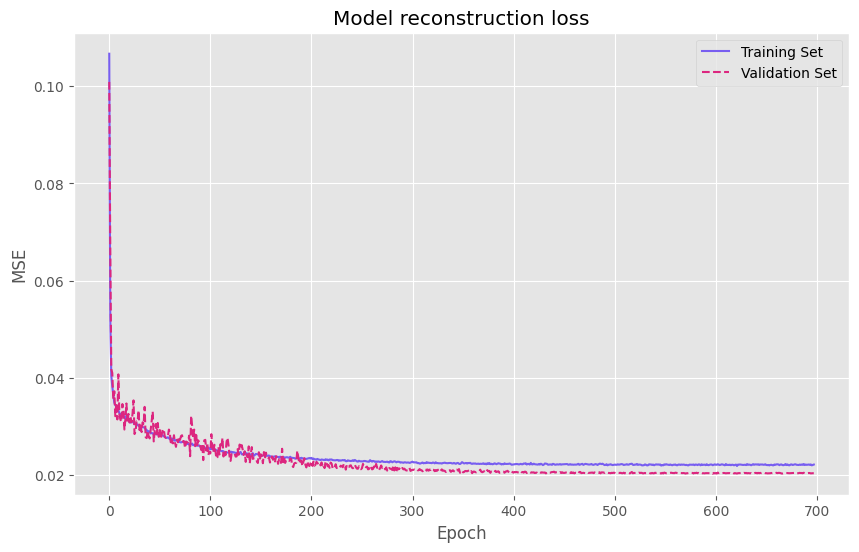

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], '--', color='#dc267f')
# plt.yscale('log')
plt.title('Model reconstruction loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()

# Fuzzy C-means

In [ ]:
!pip install fuzzy-c-means
# Step 1: Install the fuzzy-c-means package if not already installed.
# You can install it using pip:
# !pip install fuzzy-c-means

from fcmeans import FCM

c = 10
# Step 2: Preprocess the dataset
# You've already loaded the dataset into `fbc_data`.
# Now, you will select the 6 dimensions you want to use for clustering.
# Assuming these are the columns 'Housing', 'Food', 'Transportation', 'Healthcare', 'Childcare', 'Taxes'

# Select the relevant features
features = ['Housing', 'Food', 'Transportation', 'Healthcare', 'Other Necessities', 'Childcare', 'Taxes', 'median_family_income', 'num_parents', 'num_children']
f_features = fbc_data[features]

# Convert all columns to numeric type (if they are not already)
f_features = f_features.apply(pd.to_numeric, errors='coerce')

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # you can change the strategy if needed
# df_features = pd.DataFrame(imputer.fit_transform(df_features), columns=df_features.columns)

# Normalize the data
scaler = MinMaxScaler()
f_features_scaled = scaler.fit_transform(f_features)

# Step 3: Perform fuzzy c-means clustering
# Initialize the FCM with the number of clusters you want
fcm = FCM(n_clusters=c)  # Change the number of clusters according to your needs

# Fit the fuzzy c-means
encoded_data = latent_ncdr.predict(f_features_scaled)
fcm.fit(encoded_data)

# Get the cluster centers and labels
centers = fcm.centers
labels = fcm.u.argmax(axis=1)

# Step 4: Analyze the results
# You might want to add the cluster labels to your original dataframe to see which item belongs to which cluster
fbc_data['Cluster'] = labels

# You can also check the distribution of items in each cluster
cluster_distribution = fbc_data['Cluster'].value_counts()

print(fbc_data.head())
print("Cluster centers:", centers)
print("Cluster distribution:\n", cluster_distribution)

  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
982/982 [==============================] - 2s 2ms/step
  Housing   Food Transportation Healthcare Other Necessities Childcare

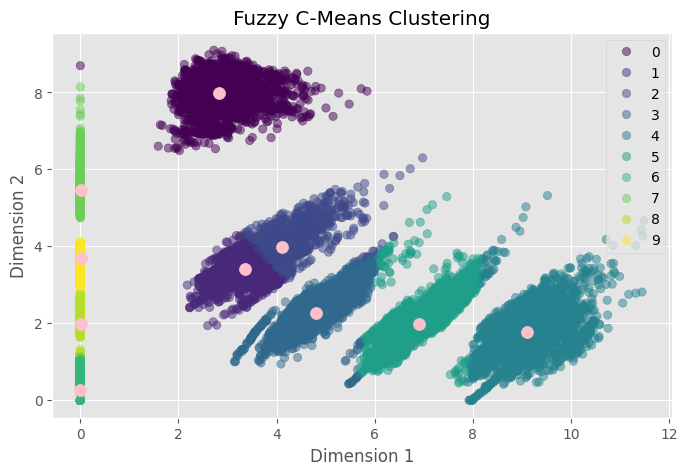

In [ ]:
import matplotlib.pyplot as plt

# Assuming `encoded_data` is 2-dimensional for visualization. If not, you should reduce it to 2 dimensions first.
# Plot the clustered data
plt.figure(figsize=(8, 5))
scatter = plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', alpha=0.5)

# Plot the centroids
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='pink', marker='.')

# Add legend and labels (adjust the legend if necessary)
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(c)))
plt.title('Fuzzy C-Means Clustering')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Show the plot
plt.show()


# Monthly average calculation

In [ ]:
category_totals = {}  # To store total amount spent for each category
category_counts = {}  # To store the number of months for each category

for key, total in category_month_totals.items():
    category, year_month = key
    year, month = year_month

    # Update total amount spent for the category
    if category in category_totals:
        category_totals[category] += total
        category_counts[category] += 1
    else:
        category_totals[category] = total
        category_counts[category] = 1

    #print(f"Category: {category}, Month: {year}/{month}, Total Amount Spent: {total}")

category_avg = {}
# Calculate and print the monthly average for each category
for category in category_totals:
    total_amount = category_totals[category]
    total_months = category_counts[category]
    average = total_amount / total_months
    category_avg[category] = average
    print(f"Category: {category}, Monthly Average: {average}")

#dave_data = [Housing  Food Transportation Healthcare Other Necessities  Childcare Taxes median_family_income  num_parents  num_children]

dave_data = [category_avg['Housing'], category_avg['Food'], category_avg['Transportation'], category_avg['Healthcare'],
             category_avg['Other Necessities'], category_avg['Childcare'], category_avg['Taxes'], yearly_income, num_parents, num_child]
print(dave_data)


Category: Misc, Monthly Average: 4108.824285714285
Category: Housing, Monthly Average: 1178.7857142857144
Category: Food, Monthly Average: 304.4538095238096
Category: Other Necessities, Monthly Average: 287.0133333333334
Category: Transportation, Monthly Average: 145.9604761904762
Category: Income, Monthly Average: 4464.285714285715
Category: Childcare, Monthly Average: 626.638571428571
Category: Healthcare, Monthly Average: 521.9807692307693
Category: Taxes, Monthly Average: 2632.5865384615386
[1178.7857142857144, 304.4538095238096, 145.9604761904762, 521.9807692307693, 287.0133333333334, 626.638571428571, 2632.5865384615386, 60000, 1, 0]


# Fitting to FCM

1/1 [==============================] - 0s 20ms/step
Predicted Cluster: [6]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


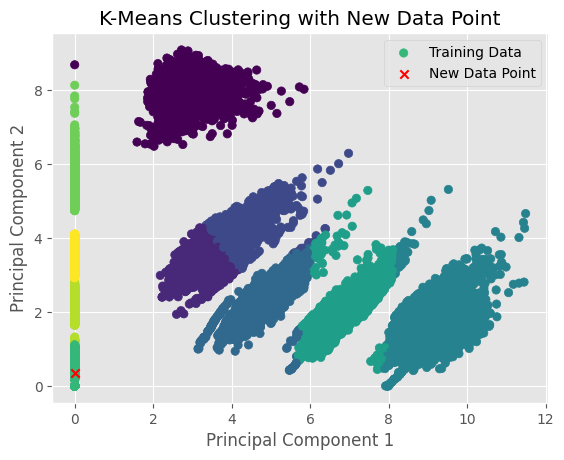

In [ ]:


data_matrix = [dave_data]

new_data_point_standardized = scaler.transform(data_matrix)

encoded_new_data_point = latent_ncdr.predict(new_data_point_standardized)

# Predict the cluster assignment using the trained k-means model
predicted_cluster = fcm.predict(encoded_new_data_point)

print("Predicted Cluster:", predicted_cluster)

# Plot the clusters
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', label='Training Data')

# Plot the new data point in red
plt.scatter(encoded_new_data_point[0, 0], encoded_new_data_point[0, 1], c='red', marker='x', label='New Data Point')

# Add labels and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with New Data Point')
plt.legend()

# Show the plot
plt.show()

# Analysis of Fitting to FCM

In [ ]:
# Analyze each cluster's characteristics
for cluster_num in range(c):
    cluster_data = fbc_data[fbc_data['Cluster'] == cluster_num].drop('Cluster', axis=1)

    # Ensure all columns are numeric
    cluster_data = cluster_data.apply(pd.to_numeric, errors='coerce')

    print(f"Cluster {cluster_num} Characteristics:")
    print(cluster_data.mean())
    print("\n-------------------\n")


Cluster 0 Characteristics:
Housing                   684.626472
Food                      489.389119
Transportation           1099.982819
Healthcare                892.390710
Other Necessities         425.384983
Childcare                   0.676742
Taxes                     549.580019
median_family_income    68340.616608
num_parents                 1.999682
num_children                0.001273
dtype: float64

-------------------

Cluster 1 Characteristics:
Housing                   733.917318
Food                      586.372067
Transportation           1166.678212
Healthcare               1160.345251
Other Necessities         478.413408
Childcare                 500.860894
Taxes                     586.688827
median_family_income    57734.764246
num_parents                 2.000000
num_children                1.000000
dtype: float64

-------------------

Cluster 2 Characteristics:
Housing                  1016.833821
Food                      641.719619
Transportation           1191.5

# Calculating Budget

Last: Calculate his budget based on his neighbors

In [ ]:
def calc_percentages(category_avg, income):
  perc = {}

  for category in category_avg:
    per = (category_avg[category]*12) / income * 100
    perc[category] = per
    # print(f"Category: {category}, Monthly Percentage: {per}")
  return perc

In [ ]:
dave_perc = calc_percentages(category_avg, yearly_income)
predicted_cluster

cluster_data = fbc_data[fbc_data['Cluster'] == predicted_cluster[0]].drop('Cluster', axis=1)
cluster_data = cluster_data.apply(pd.to_numeric, errors='coerce')

# Calculate the mean values for each category inside the cluster
cluster_avg_values = cluster_data.mean()
cluster_avg_dict = cluster_avg_values.to_dict()

# Access the mean value for the income variable
income_mean = cluster_avg_values['median_family_income']

# Pass the mean values and the income mean to calc_percentages function
cluster_perc = calc_percentages(cluster_avg_dict, income_mean)

In [ ]:
def find_key_differences(arr1, arr2):
    common_keys = set(arr1.keys()) & set(arr2.keys())
    key_differences = {}

    for key in common_keys:
        value_difference = arr1.get(key, 0) - arr2.get(key, 0)
        key_differences[key] = value_difference

    return key_differences


In [ ]:
result = find_key_differences(dave_perc, cluster_perc)
print(result)

{'Other Necessities': -1.0142010919076192, 'Housing': 10.74554001002329, 'Childcare': 7.445409588477086, 'Transportation': -14.069900647096503, 'Taxes': 44.16464169608334, 'Food': 0.277747314903241, 'Healthcare': 0.5431628437175036}


In [ ]:
weights = {
    "Housing": 0.01,
    "Healthcare": 0.001,
    "Childcare": 0.03,
    "Transportation": 0.02,
    "Other Necessities": 0.05,
    "Food": 0.04,
    "Taxes": 0.001
}

In [ ]:
def calculate_savings_needed(percent_diff, yearly_income, savings_goal, months):
    cpy_perc_dif = percent_diff.copy()
    monthly_income = yearly_income / 12
    savings_needed = {category: 0 for category in percent_diff}

    while sum(savings_needed.values()) * months < savings_goal:
      for category, diff_percentage in cpy_perc_dif.items():
        if diff_percentage > 0:
          additional_spending = monthly_income * (diff_percentage / 100)
          amount_saved = additional_spending * weights[category]
          savings_needed[category] += amount_saved
          cpy_perc_dif[category] = cpy_perc_dif[category] - (amount_saved/additional_spending)
        else:
          abs_diff_percentage = abs(diff_percentage)
          reduction_factor = 1 / (1 + (abs_diff_percentage / 100))  # Adjust the factor as needed
          additional_spending = monthly_income * (abs_diff_percentage / 100) * reduction_factor
          amount_saved = additional_spending * (weights.get(category, 1) * reduction_factor)
          savings_needed[category] += amount_saved
          cpy_perc_dif[category] -= amount_saved / additional_spending


    return savings_needed

In [ ]:
def calculate_savings_needed1(percent_diff, yearly_income, savings_goal, months):
    cpy_perc_dif = percent_diff.copy()
    monthly_income = yearly_income / 12
    savings_needed = {category: 0 for category in percent_diff}

    while sum(savings_needed.values()) * months < savings_goal:
      for category, diff_percentage in cpy_perc_dif.items():
        if diff_percentage > 0:
          additional_spending = monthly_income * (diff_percentage / 100)
          amount_saved = additional_spending * weights[category]
          savings_needed[category] += amount_saved
          cpy_perc_dif[category] = cpy_perc_dif[category] - (amount_saved/additional_spending)


    return savings_needed

In [ ]:
savings_needed_per_category = calculate_savings_needed(result, yearly_income, savings_goal, 6)
print(savings_needed_per_category)
savings_needed_per_category = calculate_savings_needed1(result, yearly_income, savings_goal, 6)
print(savings_needed_per_category)

{'Other Necessities': 16.684056066584024, 'Housing': 32.16162003006987, 'Childcare': 66.33368629629376, 'Transportation': 65.03044569767896, 'Taxes': 13.248642508825004, 'Food': 2.132967778838892, 'Healthcare': 0.16219885311525106}
{'Other Necessities': 0, 'Housing': 48.17493004510481, 'Childcare': 98.89302944444064, 'Transportation': 0, 'Taxes': 19.872288763237506, 'Food': 2.208462408645374, 'Healthcare': 0.2426232796728766}


In [ ]:
def display_dictionary_as_dollars(dictionary):
    max_key_length = max(len(str(key)) for key in dictionary.keys())
    print(f"{'Category':<{max_key_length + 5}} | Amount to save per month")
    print("---------------------------------------------------")
    for key, value in dictionary.items():
        print(f"{key:<{max_key_length + 5}} | ${value:.2f}")

# Savings Plans

In [ ]:
savings_needed_per_category = calculate_savings_needed(result, yearly_income, savings_goal, 6)
print("Savings plan for 6 months")
print("---------------------------------------------------")
display_dictionary_as_dollars(savings_needed_per_category)
print()
savings_needed_per_category = calculate_savings_needed(result, yearly_income, savings_goal, 12)
print("Savings plan for 12 months")
print("---------------------------------------------------")
display_dictionary_as_dollars(savings_needed_per_category)
print()
savings_needed_per_category = calculate_savings_needed(result, yearly_income, savings_goal, 24)
print("Savings plan for 24 months")
print("---------------------------------------------------")
display_dictionary_as_dollars(savings_needed_per_category)
print()

Savings plan for 6 months
---------------------------------------------------
Category               | Amount to save per month
---------------------------------------------------
Other Necessities      | $16.68
Housing                | $32.16
Childcare              | $66.33
Transportation         | $65.03
Taxes                  | $13.25
Food                   | $2.13
Healthcare             | $0.16

Savings plan for 12 months
---------------------------------------------------
Category               | Amount to save per month
---------------------------------------------------
Other Necessities      | $7.81
Housing                | $16.10
Childcare              | $33.37
Transportation         | $32.47
Taxes                  | $6.62
Food                   | $1.43
Healthcare             | $0.08

Savings plan for 24 months
---------------------------------------------------
Category               | Amount to save per month
---------------------------------------------------
Other Necessit